In [1]:
from modules.dataloader import XView3Data
import numpy as np
from torch.utils.data import DataLoader
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from modules.metric import score, compute_loc_performance
import numpy as np
from tqdm import tqdm
import cv2, os
import rasterio
from rasterio.enums import Resampling
import torchvision
from torch.utils.tensorboard import SummaryWriter
import joblib

In [2]:
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))

0 TITAN Xp
1 TITAN X (Pascal)
2 Quadro K420


/home/xview3/anaconda3/envs/xview3/lib/python3.9/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 Quadro K420 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [3]:
device_DN = torch.device("cuda:1")
device_RPN = torch.device("cuda:1")

## Model Preparation

In [4]:
from torchvision.models import resnet50
from torchvision import io, transforms as T

transform = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# img = io.read_image("./lion.jpg")/255
# img = transform(img).reshape(1,3,224,224)
# img = img.to(device)

In [5]:
from modules.featextract import FeatureExtractor
from modules.model import RPN, DN
from modules.config import load_model_config
from modules.utils import evaluate, save_fig, convert_prob_to_image, prepare_label

In [6]:
def prepare_backbone():
    backbone = resnet50(pretrained=True)
    for param in backbone.parameters():
        param.requires_grad = False
    backbone = backbone.eval()
    
    return backbone

In [9]:
rpn = torch.nn.Sequential(*[FeatureExtractor(load_model_config(prepare_backbone())), RPN(128)])
rpn.load_state_dict(torch.load("/media/xview/xview3_challenge/xView3-Challenge/exps/ckpts/RPN_4_trained_model_3_epochs.pth"))
rpn.to(device_RPN)
rpn.eval()
print()

In [8]:
dn = torch.nn.Sequential(*[FeatureExtractor(load_model_config(prepare_backbone())), DN(128, 4)])
dn.load_state_dict(torch.load("/media/xview/xview3_challenge/xView3-Challenge/exps/ckpts/DN_6_trained_model_3_epochs.pth"))
dn.to(device_DN)
dn.eval()
print()

In [100]:
# import joblib
# import xgboost as xgb

# xgb_clf = xgb.XGBClassifier()
# xgb_clf.load_model("xgb_model.json")

# scaler = joblib.load("scaler.joblib")

## Dataloading

In [12]:
def preprocess_label(df):
    df = df.dropna(subset=["is_vessel"])
    return df


val_data_path = "/media/xview/xview3_challenge/dataset/data/validation"
val_label_path = "/media/xview/xview3_challenge/dataset/labels/validation1.csv"


val_data = XView3Data(background_chip_ratio=0.0, obj_size=5, threshold=0.25, overwrite=True,
                        labels_path=val_label_path, data_path=val_data_path, preprocess_label=preprocess_label)

Total scenes detected: 50
	Processing scene: 36076e547370064ev
	Saving in labels.json
	Total chips extracted: 203
		Background chips: 0
		Foreground chips: 203
	Processing scene: 758991708403f218v
	Saving in labels.json
	Total chips extracted: 98
		Background chips: 0
		Foreground chips: 98
	Processing scene: 7b7e837a7ac5a880v
	Saving in labels.json
	Total chips extracted: 121
		Background chips: 0
		Foreground chips: 121
	Processing scene: 3fe00bf7beab8812v
	Saving in labels.json
	Total chips extracted: 194
		Background chips: 0
		Foreground chips: 194
	Processing scene: 4a97701b4bd81bf7v
	Saving in labels.json
	Total chips extracted: 127
		Background chips: 0
		Foreground chips: 127
	Processing scene: 335f9a411884e9cbv
	Saving in labels.json
	Total chips extracted: 112
		Background chips: 0
		Foreground chips: 112
	Processing scene: 75c03770095c6d9ev
	Saving in labels.json
	Total chips extracted: 43
		Background chips: 0
		Foreground chips: 43
	Processing scene: 5e9a2c1bcf179e9bv
	Sa

In [19]:
def joint_prob(fa, sr):
    
    joint_prob = torch.clone(sr)
    joint_prob[:, 0, :, :] = (1-fa).squeeze(dim=1) * sr[:, 0, :, :]
    joint_prob[:, 1:, :, :] = fa * sr[:, 1:, :, :]
    
    Z = torch.sum(joint_prob, dim=1, keepdim=True)
    
    p_ci = joint_prob / Z

    return p_ci

def get_detections(joint_prob):

    detections = []
    y_arr = joint_prob.detach().cpu().numpy()

    y_cls = np.argmax(y_arr, axis=0)
    y_prob = y_arr.max(axis=0)
    y_prob_fg = 1 - y_arr[0, :, :]
    
    y_bin = ((y_prob_fg >= 0.5)*(y_cls!=0)).astype(np.uint8)
    contours, _ = cv2.findContours(y_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    for contour in contours:
        ix, iy = contour[:, :, 0], contour[:, :, 1]
        M = cv2.moments(contour)
        if M['m00'] == 0 and len(contour) != 0:
            cx = 0
            cy = 0
            for p in contour:
                cx += p[0][0]
                cy += p[0][1]
            cx = int(cx/len(contour))
            cy = int(cy/len(contour))
        elif len(contour) != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        else:
            continue
        
        cls_arr = y_cls[iy, ix]
        val, cnt = np.unique(cls_arr, return_counts=True)
        cls = val[np.argmax(cnt)]
        prob = y_prob[iy, ix][cls_arr == cls].mean()
        
        detections.append((cx, cy, cls, prob, len(contour)))
        
    return detections

# def get_detections(joint_prob, num_classes = 3):

#     detections = []
#     y_arr = joint_prob.detach().cpu().numpy()

#     y_cls = np.argmax(y_arr, axis=0)
#     y_prob = y_arr.max(axis=0)

#     for i in range(1, num_classes+1):
#         cls = i
#         y_bin = ((y_cls == i)*(y_prob >= 0.9)).astype(np.uint8)

#         contours, _ = cv2.findContours(y_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

#         for contour in contours:
#             ix, iy = contour[:, :, 0], contour[:, :, 1]
#             M = cv2.moments(contour)
#             if M['m00'] == 0 and len(contour) != 0:
#                 cx = 0
#                 cy = 0
#                 for p in contour:
#                     cx += p[0][0]
#                     cy += p[0][1]
#                 cx = int(cx/len(contour))
#                 cy = int(cy/len(contour))
#             elif len(contour) != 0:
#                 cx = int(M['m10']/M['m00'])
#                 cy = int(M['m01']/M['m00'])
#             else:
#                 continue
#             detections.append((cx, cy, cls, y_prob[iy, ix].max(), cv2.contourArea(contour)))
        
#     return detections

# def get_detections(proposal, class_pred, num_classes=3, threshold=0.7):

#     detections = []

#     proposal = proposal.detach().cpu().numpy()
#     y_arr = class_pred.detach().cpu().numpy()

#     y_cls = np.argmax(y_arr, axis=0)
#     y_prob = y_arr.max(axis=0)
    
#     contours, _ = cv2.findContours((proposal.squeeze() >= threshold).astype("uint8"), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
#     for contour in contours:
#         area = cv2.contourArea(contour)
#         if area <= 90:
#             continue
#         ix, iy = contour[:, :, 0], contour[:, :, 1]
#         M = cv2.moments(contour)
#         if M['m00'] == 0 and len(contour) != 0:
#             cx = 0
#             cy = 0
#             for p in contour:
#                 cx += p[0][0]
#                 cy += p[0][1]
#             cx = int(cx/len(contour))
#             cy = int(cy/len(contour))
#         elif len(contour) != 0:
#             cx = int(M['m10']/M['m00'])
#             cy = int(M['m01']/M['m00'])
#         else:
#             continue
        
#         cls_arr = y_cls[iy, ix]
#         val, cnt = np.unique(cls_arr, return_counts=True)
#         if len(val) == 1 and val[0] == 0:
#             continue
            
#         val, cnt = val[val!=0], cnt[val!=0]
#         cls = val[np.argmax(cnt)]
#         prob = y_prob[iy, ix][cls_arr == cls].max()    
#         detections.append((cx, cy, cls, prob, cv2.contourArea(contour)))
        
#     return detections

In [13]:
scene_ids = list(set([uid.split("_")[0] for uid in val_data.data_ixs]))

In [14]:
def load_tiff(path, out_shape, k=(49,49)):
    data = rasterio.open(path).read(out_shape=out_shape, resampling=Resampling.bilinear).squeeze()
    
    blur_data = cv2.GaussianBlur(data, k, cv2.BORDER_DEFAULT)
    return blur_data

In [15]:
def T(img):
    return np.transpose(img.cpu().numpy(), (1,2,0))

In [ ]:
# 111 116m 124 125m 139 140 154m 350

In [79]:
# dataset = val_data



# l = len(dataset.data_ixs)
# for i, uid in enumerate([dataset.data_ixs[350]], 1):
#     scene_id, chip_row, chip_col = uid.split("$")
#     chip_row, chip_col = int(chip_row), int(chip_col)
    
#     scene = dataset.scenes[scene_id]
#     rgb_img, flag = scene[chip_row, chip_col]
    
#     (strt_r, strt_c), _ = scene.get_full_index(chip_row, chip_col)
    
#     with torch.no_grad():
#         rgb_img = torch.from_numpy(np.expand_dims(rgb_img, 0))
        
#         img = transform(rgb_img)
#         proposal = rpn(img.to(device_RPN))
#         class_pred = dn(img.to(device_DN))
#         labels = scene.labels[uid]
#         class_labels, _ = prepare_label(labels, dataset.chipsize, 
#                                             dataset.obj_size, dataset.threshold, fishing=True)
#         class_true = torch.from_numpy(class_labels)
        
#         pred_im = convert_prob_to_image(class_pred[0], pred=True)
#         true_im = convert_prob_to_image(class_true)
        
# plt.figure(figsize=(10,10))
# plt.imshow(T(rgb_img[0]))
# plt.axis("off")
# plt.show()

# plt.figure(figsize=(10,10))
# plt.imshow(T(pred_im))
# plt.axis("off")
# plt.show()

# plt.figure(figsize=(10,10))
# plt.imshow(T(true_im))
# plt.axis("off")
# plt.show()

# plt.figure(figsize=(10,10))
# plt.imshow(T(proposal[0]), cmap="gray")
# plt.axis("off")
# plt.show()

# # plt.figure(figsize=(20,20))
# # plt.imshow((class_labels!=0).astype("uint8"), cmap="gray")
# # plt.axis("off")
# # plt.show()

In [ ]:
# dataset = val_data
# raster = "/bathymetry.tif"
# predictions={
#     "center_x":[],
#     "center_y":[],
#     "scene_id":[],
#     "class":[],
#     "prob":[],
#     "scene_h":[],
#     "scene_w":[],
#     "area":[]
# }

# for scene_id in scene_ids:
#     print(f"\nProcessing {scene_id}:")
#     uids = list(filter(lambda x: x.split("_")[0]==scene_id, dataset.data_ixs))
#     scene = dataset.scenes[scene_id]
#     path = scene.path+raster
#     bathymetry = load_tiff(path, out_shape=(1, scene.row, scene.col))
    
#     X, y = [], []
#     l = len(uids)
#     for i, uid in enumerate(uids):
#         _, chip_row, chip_col = uid.split("_")
#         chip_row, chip_col = int(chip_row), int(chip_col)
        
#         rgb_img, flag = scene[chip_row, chip_col]

#         (strt_r, strt_c), _ = scene.get_full_index(chip_row, chip_col)

#         with torch.no_grad():
#             rgb_img = torch.from_numpy(np.expand_dims(rgb_img, 0))

#             img = transform(rgb_img)
#             feat = dn[0](img.to(device_DN))
#             feat = feat.squeeze().cpu().numpy()
            
#             try:
#                 f, b = feat.reshape(-1, 800*800), bathymetry[strt_r:strt_r+dataset.chipsize, 
#                                                      strt_c:strt_c+dataset.chipsize]
#                 h_b, w_b = b.shape
#                 b = np.pad(b, ((0, 800-h_b), (0, 800-w_b)), constant_values=-32768)
#                 b = b.reshape(-1)
                
#             except IndexError:
#                 continue
#             else:
#                 x = np.hstack([f.transpose((1,0)), b.reshape(-1,1)])
#                 scaled_x = scaler.transform(x)
#                 pred = xgb_clf.predict_proba(scaled_x).reshape(800, 800, 4)
                
#                 class_pred = torch.from_numpy(np.transpose(pred, (2, 0, 1)))
#                 detections = get_detections(class_pred)
                
#                 print(f"\r{i+1}/{l} processing... got detections: {len(detections)}  ", end="")

#                 for (center_x, center_y, cls, prob, area) in detections:
#                     center_x += strt_c
#                     center_y += strt_r

#                     predictions["center_x"].append(center_x)
#                     predictions["center_y"].append(center_y)
#                     predictions["scene_id"].append(scene_id)
#                     predictions["class"].append(cls)
#                     predictions["prob"].append(prob)
#                     predictions["scene_h"].append(scene.row)
#                     predictions["scene_w"].append(scene.col)
#                     predictions["area"].append(area)
#     del bathymetry
    
# df = pd.DataFrame(predictions)
# df.to_csv("./val_submission_ensemble.csv", index=False)

In [23]:
# writer = SummaryWriter("/media/xview/xview3_challenge/xView3-Challenge/exps/runs/validation_perf_1")

In [108]:
predictions={
    "center_x":[],
    "center_y":[],
    "scene_id":[],
    "class":[],
    "prob":[],
    "scene_h":[],
    "scene_w":[],
    "area":[]
}

dataset = val_data

# joblib.dump(dataset.data_ixs, "dataset_ixs.joblib")

# pred_im = []
# true_im = []

l = len(dataset.data_ixs)
for i, uid in enumerate(dataset.data_ixs, 1):
    scene_id, chip_row, chip_col = uid.split("$")
    chip_row, chip_col = int(chip_row), int(chip_col)
    
    scene = dataset.scenes[scene_id]
    rgb_img, flag = scene[chip_row, chip_col]
    
    (strt_r, strt_c), _ = scene.get_full_index(chip_row, chip_col)
    
    with torch.no_grad():
        rgb_img = torch.from_numpy(np.expand_dims(rgb_img, 0))
        
        img = transform(rgb_img)
#         proposal = rpn(img.to(device_RPN))
        class_pred = dn(img.to(device_DN))
#         labels = scene.labels[uid]
#         class_labels, _ = prepare_label(labels, dataset.chipsize, 
#                                             dataset.obj_size, dataset.threshold, fishing=True)
#         class_true = torch.from_numpy(class_labels)
        
#         pred_im.append(convert_prob_to_image(class_pred[0], pred=True))
#         true_im.append(convert_prob_to_image(class_true))
        
#         if i%4 == 0:
#             writer.add_image(f'eval_class_prediction', torchvision.utils.make_grid(pred_im, nrow=2), global_step=i)
#             writer.add_image(f'eval_class_true', torchvision.utils.make_grid(true_im, nrow=2), global_step=i)
#             pred_im = []
#             true_im = []
        
#         detections = get_detections(joint_prob(proposal, class_pred)[0])
        detections = get_detections(class_pred[0])
#         detections = get_detections(proposal[0], class_pred[0])
    
        print(f"\r{i}/{l} processing... got detections: {len(detections)}  ", end="")
        
        for (center_x, center_y, cls, prob, area) in detections:
            center_x += strt_c
            center_y += strt_r
            
            predictions["center_x"].append(center_x)
            predictions["center_y"].append(center_y)
            predictions["scene_id"].append(scene_id)
            predictions["class"].append(cls)
            predictions["prob"].append(prob)
            predictions["scene_h"].append(scene.row)
            predictions["scene_w"].append(scene.col)
            predictions["area"].append(area)

df = pd.DataFrame(predictions)
df.to_csv("./val_submission_9.csv", index=False)
# writer.close()

11139/11139 processing... got detections: 0   

In [26]:
# plt.imshow(proposal.squeeze().cpu().numpy() > 0.7, cmap="gray")
# plt.show()

# plt.imshow(np.transpose(convert_prob_to_image(class_pred[0], pred=True), [2, 1, 0]))
# plt.show()

# plt.imshow(np.transpose(convert_prob_to_image(joint_prob(proposal, class_pred)[0], pred=True), [2, 1, 0]))
# plt.show()

# # contours, _ = cv2.findContours((proposal.squeeze().cpu().numpy() > 0.7).astype("uint8"), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# # for cnt in contours:
# #     print(cv2.contourArea(cnt))

In [109]:
def suppress_land_detections(pred, owi_mask_file, k=10):
    
    predictions = pd.DataFrame()
    
    for scene_id in tqdm(np.unique(pred["scene_id"])):
        pred_scene = pred[pred["scene_id"] == scene_id]
        folder_path = os.path.join(owi_mask_file, scene_id)
        file_path = os.path.join(folder_path, "owiMask.tif")
        
        src = rasterio.open(file_path)
        mask = src.read(1)
        mask = (mask == 0).astype("uint8")
        
        h, w = pred_scene.iloc[0]["scene_h"], pred_scene.iloc[0]["scene_w"]
        
        mask = cv2.dilate(mask, np.ones((k, k), np.uint8))
        mask = cv2.resize(mask, (w, h), interpolation = cv2.INTER_LINEAR)
        
        
        det_r, det_c = pred_scene["detect_scene_row"].values, pred_scene["detect_scene_column"].values
        
        ix_bool = (det_r < h) & (det_c < w)
        det_r = det_r[ix_bool]
        det_c = det_c[ix_bool]
        ix = np.where(mask[det_r, det_c] == 1)[0]
        
        predictions = pd.concat([predictions, pred_scene.iloc[ix]]).reset_index(drop=True)
    
    print(f"Removed {len(pred) - len(predictions)} detections from {len(pred)} detections")
    return predictions

In [110]:
def drop_scenes(df):
    ids = ['2e80028071b89173v_val', '8204efcfe9f09f94v_val', '487b4884f467c94av_val', '6a2b6ddecd398c6fv_val']
    for id in ids:
        df.drop(index=df[df["scene_id"] == id].index, inplace=True)
    
    return df.reset_index()

In [111]:
pred = df.copy()
# pred = pd.read_csv("./val_submission_5.csv")
gt = pd.read_csv("/media/xview/xview3_challenge/dataset/labels/validation1.csv")
gt = drop_scenes(gt)
shore_root = "/media/xview/xview3_challenge/dataset/Shoreline_data/validation"


pred["is_vessel"] = ((pred["class"] == 1) | (pred["class"] == 2))

pred["is_fishing"] = pred["class"] == 1

pred["vessel_length_m"] = 30.0

pred["detect_scene_row"] = pred["center_y"]
pred["detect_scene_column"] = pred["center_x"]

In [112]:
pred.shape

(14989, 13)

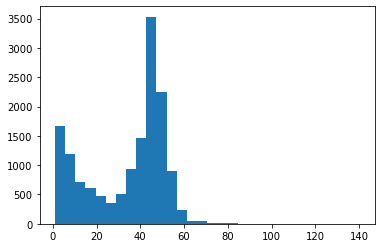

In [113]:
plt.hist(pred[pred["area"]<=150]["area"], bins=30)
plt.show()

In [114]:
[i for i in gt["scene_id"].unique() if i not in pred["scene_id"].unique()]

[]

In [115]:
score(pred, gt, shore_root)

100%|███████████████████████████████████████████| 45/45 [00:30<00:00,  1.47it/s]


{'loc_fscore': 0.5547514159848961,
 'loc_fscore_shore': 0.14326170248209227,
 'vessel_fscore': 0.8629869462431904,
 'fishing_fscore': 0.7699115044247788,
 'length_acc': 0.448241235936641,
 'aggregate': 0.35774824725990284}

In [124]:
score(pred[(pred["area"] >= 25) & (pred["area"] <= 150)].reset_index(drop=True), gt, shore_root)

100%|███████████████████████████████████████████| 45/45 [00:20<00:00,  2.24it/s]


{'loc_fscore': 0.6433391099148262,
 'loc_fscore_shore': 0.12276313257648644,
 'vessel_fscore': 0.8674348593376934,
 'fishing_fscore': 0.7743940335612182,
 'length_acc': 0.44696784888004426,
 'aggregate': 0.4132244142012003}

In [98]:
score(pred[(pred["area"] >= 15) & (pred["area"] <= 150)].reset_index(drop=True), gt, shore_root)

100%|███████████████████████████████████████████| 45/45 [00:18<00:00,  2.43it/s]


{'loc_fscore': 0.6296489140136864,
 'loc_fscore_shore': 0.17004624688722872,
 'vessel_fscore': 0.8718294917542676,
 'fishing_fscore': 0.7941363926067558,
 'length_acc': 0.44351936743018705,
 'aggregate': 0.41299068932331134}

In [188]:
score(pred[(pred["area"] >= 10) & (pred["area"] <= 1000)].reset_index(drop=True), gt=gt, shore_root=shore_root)

100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.00it/s]


{'loc_fscore': 0.3587805675665855,
 'loc_fscore_shore': 0.036585365853658534,
 'vessel_fscore': 0.8826707834812815,
 'fishing_fscore': 0.7239819004524887,
 'length_acc': 0.4108311553687538,
 'aggregate': 0.21914813656271317}

In [107]:
score(pred=pred[(pred["prob"] >= 0.5) & (pred["area"] >= 110) & (pred["area"] <= 750)].reset_index(drop=True), gt=gt, shore_root=shore_root)

100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  3.10it/s]


{'loc_fscore': 0.3481793447877455,
 'loc_fscore_shore': 0.060377358490566045,
 'vessel_fscore': 0.7938501515807711,
 'fishing_fscore': 0.6778149386845039,
 'length_acc': 0.48862975286846166,
 'aggregate': 0.21034713359602128}

In [58]:
predictions = suppress_land_detections(pred, "/media/xview/xview3_challenge/dataset/data/owiMask-val", k=10)

100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.01it/s]

Removed 402 detections from 12833 detections


In [69]:
score(pred=predictions[predictions["area"] >= 20].reset_index(drop=True), gt=gt, shore_root=shore_root)

100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.80it/s]


{'loc_fscore': 0.6212705015855696,
 'loc_fscore_shore': 0.10154071900220103,
 'vessel_fscore': 0.8666797180892718,
 'fishing_fscore': 0.7696933253156945,
 'length_acc': 0.4447609383188643,
 'aggregate': 0.3954603815407528}

In [11]:
## Best so far

In [190]:
score(pred=predictions.reset_index(drop=True), gt=gt, shore_root=shore_root)

100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.04it/s]


{'loc_fscore': 0.3580808264522935,
 'loc_fscore_shore': 0.03498047206656478,
 'vessel_fscore': 0.8828200658531861,
 'fishing_fscore': 0.7231467473524963,
 'length_acc': 0.4111345282322506,
 'aggregate': 0.21857839563594106}

In [279]:
score(pred=predictions[(predictions["prob"] >= 0.5) & (predictions["area"] >= 110) & (predictions["area"] <= 750)].reset_index(drop=True), gt=gt, shore_root=shore_root)

100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.68it/s]


{'loc_fscore': 0.5925297689724193,
 'loc_fscore_shore': 0.11664538101319709,
 'vessel_fscore': 0.791472032578752,
 'fishing_fscore': 0.7344947735191637,
 'length_acc': 0.4329813911724997,
 'aggregate': 0.364476150478689}

In [54]:
score(pred[pred["area"] >= 20].reset_index(drop=True), gt, shore_root)

100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.65it/s]


{'loc_fscore': 0.620715350223547,
 'loc_fscore_shore': 0.10810027532241703,
 'vessel_fscore': 0.866990291262136,
 'fishing_fscore': 0.7701492537313434,
 'length_acc': 0.4434678888939205,
 'aggregate': 0.39585596449653915}

In [18]:
from modules.metric import compute_loc_performance

In [19]:
tp_inds, fp_inds, fn_inds = compute_loc_performance(pred[pred["area"] >=20].reset_index(drop=True), gt)

In [22]:
precision = len(tp_inds)/(len(tp_inds)+len(fp_inds))

In [23]:
recall = len(tp_inds)/(len(tp_inds)+len(fn_inds))

In [24]:
print(f"Precision: {precision}, Recall: {recall}")

Precision: 0.9028155339805826, Recall: 0.4837182688306284
